Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/gpiosenka/musical-instruments-image-classification
License(s): CC0-1.0
musical-instruments-image-classification.zip: Skipping, found more recently modified local copy (use --force to force download)
replace 6 test samples/1.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename:  acordian      casaba	    Didgeridoo	 guitar      piano	   trombone
 alphorn       castanets    drums	 harmonica   saxaphone	   trumpet
 bagpipes      clarinet     dulcimer	 harp	     sitar	   tuba
 banjo	       clavichord   flute	 marakas    'steel drum'   violin
'bongo drum'   concertina   guiro	 ocarina     Tambourine    Xylophone
 acordian      casaba	    Didgeridoo	 guitar      piano	   trombone
 alphorn       castanets    drums	 harmonica   saxaphone	   trumpet
 bagpipes      clarinet     dulcimer	 harp	     sitar	   tuba
 banjo	       clavichord   flute	 marakas    'steel drum'   violin
'bongo drum'   concertina   guiro	 ocarina     Tambou


Test Accuracy: 99.33%
Model saved successfully!


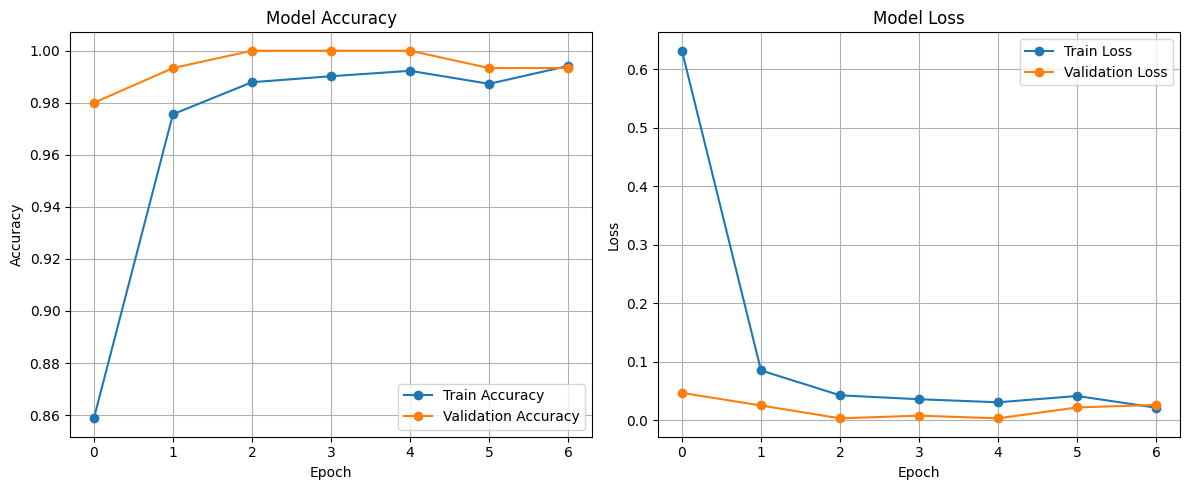

In [4]:
# Install and setup Kaggle
!pip install -q kaggle
from google.colab import files
files.upload()  # Upload your kaggle.json
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Download and extract dataset
!kaggle datasets download -d gpiosenka/musical-instruments-image-classification
!unzip -q musical-instruments-image-classification.zip

# Define paths and parameters
train_dir = 'train'
test_dir = 'test'
img_size = (299, 299)
batch_size = 32

# Verify directory contents
!ls train
!ls test

# Import libraries
import tensorflow as tf
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

# Data generators with augmentation for training
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# Build the model
base_model = InceptionResNetV2(
    weights='imagenet',
    include_top=False,
    input_shape=(*img_size, 3)
)
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
predictions = Dense(train_generator.num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer=Adam(0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(
    train_generator,
    epochs=7,
    validation_data=test_generator
)

# Evaluate the model
loss, accuracy = model.evaluate(test_generator)
print(f"\nTest Accuracy: {accuracy * 100:.2f}%")

# Save the model
model.save("instrument_classifier.h5")
print("Model saved successfully!")

# Plot accuracy and loss graphs
plt.figure(figsize=(12, 5))

# Accuracy graph
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Loss graph
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step


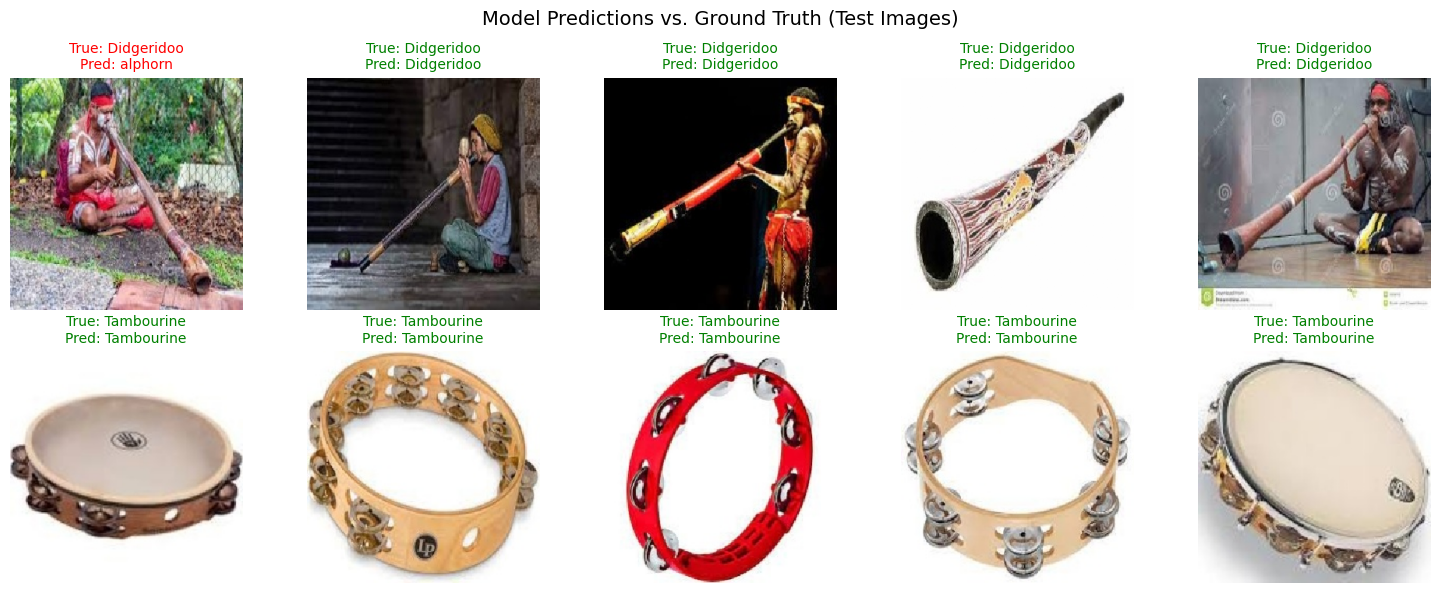


✅ Test Accuracy: 99.33%


In [5]:
# --- Predict and Show Actual vs. Predicted Labels ---
# Reset the generator to start from the beginning
test_generator.reset()

# Get a batch of test images and true labels
images, true_labels = next(test_generator)

# Predict using the model
pred_probs = model.predict(images)
pred_indices = np.argmax(pred_probs, axis=1)
true_indices = np.argmax(true_labels, axis=1)

plt.figure(figsize=(15, 6))
for i in range(10):
    ax = plt.subplot(2, 5, i + 1)
    plt.imshow((images[i] + 1) / 2)
    true_label = label_map[true_indices[i]]
    pred_label = label_map[pred_indices[i]]
    color = "green" if true_label == pred_label else "red"
    plt.title(f"True: {true_label}\nPred: {pred_label}", color=color, fontsize=10)
    plt.axis("off")

plt.suptitle("Model Predictions vs. Ground Truth (Test Images)", fontsize=14)
plt.tight_layout()
plt.show()
# --- Evaluate test accuracy on entire test set ---
loss, accuracy = model.evaluate(test_generator, verbose=0)
print(f"\n✅ Test Accuracy: {accuracy * 100:.2f}%")
